# How do various factors like region, fans owned, etc. affect people's sentiments and polarization on social media during the 2020 US election?
### Zihao(Gavin) Zou, 1006668429, zihao.zou@mail.utoronto.ca

# 1. Project 1

## 1.1 Introduction

Social media posts have been the target of social research for a long time. With the utilization of computer programs and AI databases, researchers can gain more insights from the posts. In this report, I explore how various factors can show a predictive effect on people's sentiments and polarization during the 2020 US Presidential election using tweets. The Y variable is the polarization score, while the X variables are state, followers, user join date, country, and tweet posted time. 

The polarization score is calculated using the tool pack called TextBlob. TextBlob connects to a large natural language processing model that is continuously developed. This model takes in a sentence and calculates the polarization score that ranges from -1 to 1, where a negative one shows extremely assertive, aggressive or hostile, while one indicates extremely approachable or positive. This score is believed to identify people's sentiments and polarization accurately, so I am using data generated by this tool pack in this research.

For the five X variables I choose, the reasonings are as below. First, the state shows how the location within the United States affects what people discuss. Second, the country shows how international regions will affect topic popularities. Third, join data is an implication of a person's internet experience, and we observe how that could affect people's choice of topics. Fourth, followers show how social media influence can affect people's participation in different issues. Last, created date identifies how topics trend over a period of time. Meanwhile, from the data below, the graphs have shown apparent relationships between the five variables and the polarization score.

This report is separated into two parts. The first part is on some basic summary statistic tables and general graphs, which I use to refer to a general relationship between the Y and X variables. The second part goes into more detail on the graphs and maps, where I will present more specific visual and geographical relationships if they exist.

*The data is taken by MANCH HUI, taken directly from Twitter. Downloaded from:
https://www.kaggle.com/datasets/manchunhui/us-election-2020-tweets

In [1]:
# First import necessary toolpacks needed
import math
import csv
from math import isnan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime
# import tools for mapping
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
%matplotlib inline
# activate plot theme
import qeds

## 1.2 Data cleaning
Before doing any data analysis, we need to clean the data first.
I first start with merging and X varialbes cleaning

In [2]:
# import the datasets and work on data cleaning
dotru = pd.read_csv('/Users/gavinhao/Programming/UT_ECO225/Data/archive/hashtag_donaldtrump.csv',lineterminator='\n')
bid = pd.read_csv('/Users/gavinhao/Programming/UT_ECO225/Data/archive/hashtag_joebiden.csv',lineterminator='\n')
# merge the two datasets
dotru["hashtag"] = 'trump'
bid["hashtag"] = "biden"
tweet = pd.concat([dotru,bid])
# because we are merging by hashtag, there will be repeated values
# checking the repeated value
print(tweet.duplicated(subset=["tweet"]).sum())

240600


In [3]:
# so there are 240,600 repeated tweets, removing it:
tweet.drop_duplicates(subset=["tweet"], inplace=True, keep=False)
print(tweet.duplicated(subset=["tweet"]).sum())

0


In [4]:
# For simplicity, I also round data and time to the nearest day for created_at
# we generated a new column for created_at, named as "created_time"
tweet["created_at"] = pd.to_datetime(tweet.created_at)
# then, we rounded this object according to days
tweet["created_time"] = tweet["created_at"].dt.round("D")

In [5]:
# For simplicity, I also round data and time to the nearest year for user_join_date
# we generated a new column for user_join_year, named as "join_year"
tweet["user_join_date"] = pd.to_datetime(tweet.user_join_date)
# then, we rounded this object according to 365 days
tweet["join_year"] = tweet["user_join_date"].dt.round("365D")
# then, we round join_year to year
for i in range(len(tweet)):
    timestamp = pd.Timestamp(tweet.iloc[i,23])
    a = timestamp.to_pydatetime()
    tweet.iloc[i,23] = a.year

Now we deal with Y variable

In [6]:
# Before calculating the polarity score, I am also interested in the topics that people are dicussing
# Becasue topics that people engage in may show predictive effect of their polarity score
# Therefore, I also get all the hashtags out of tweets for further research of my own interest
# HOWEVER, for the entire file and codes to run, please ALSO run this sub-segmants of codes
tweet["other_hash"] = 'NaN' # at columns 24, create new variable
for a in range(len(tweet)):
    content = tweet.iloc[a,2].split()
    for b in range(len(content)):
        if content[b].startswith("#"):
            if tweet.iloc[a,24] == 'NaN':
                tweet.iloc[a,24] = ''
            cleaned_hashtag = content[b].strip(":").strip("?").upper()
            tweet.iloc[a,24] = tweet.iloc[a,24] + cleaned_hashtag +' '
# WARNING: because we have almost 1,300,000 tweets in the merged file, this loop is likely going to
# take you more than 4 mins to run - because it checks each single word in all 
# the tweets to identify the hashtags
# it takes about 5 mins to run on MacBook with M1 Pro chip

We now add a new column to show the polarity score

In [7]:
tweet["polar_score"] = 0 # at columns 25, create new variable
for a in range(len(tweet)):
    score = TextBlob(tweet.iloc[a,2])
    tweet.iloc[a,25] = score.sentiment.polarity
# WARNING: because we have almost 1,300,000 tweets in the merged file, this loop is likely going to
# take you more than 2 mins to run - because it checks each single word in all 
# the tweets to identify the value
# it takes about 3 mins to run on MacBook with M1 Pro chip

In [8]:
# take a look at the dataset
tweet.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,country,continent,state,state_code,collected_at,hashtag,created_time,join_year,other_hash,polar_score
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530,trump,2020-10-15,2011,#DONALDTRUMP,0.000000
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060,trump,2020-10-15,2007,#TRUMP,0.333333
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,trump,2020-10-15,2008,#TRUMP #IOWA,0.000000
5,2020-10-15 00:00:17,1.316529e+18,@CLady62 Her 15 minutes were over long time ag...,2.0,0.0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,#BidenHarris2020 #JoeBiden2020 #KamalaHarrisFo...,...,United States of America,North America,California,CA,2020-10-21 00:00:01.866082651,trump,2020-10-15,2012,#THEREIDOUT #TRUMP,-0.155208
6,2020-10-15 00:00:17,1.316529e+18,@richardmarx Glad u got out of the house! DICK...,0.0,0.0,Twitter for iPhone,7.674018e+17,Michael Wilson,wilsonfire9,NaN,...,NaN,NaN,NaN,NaN,2020-10-21 00:00:02.239299182,trump,2020-10-15,2016,NaN,0.625000


In [9]:
tweet.to_csv('/Users/gavinhao/Programming/UT_ECO225/Data/archive/sorted.csv')
# Save a new file just in case we get lost somewhere
# This file is likely to have a size of 700+ MB

Now the data is merged into one file called "sorted," and all data are cleaned, we start digging into our research question.

The cleaned dataframe is called "tweet"

## 1.3 Summary Statistic Tables

In [10]:
# 1st X variable(created time) summary
tweet["created_time"].describe(datetime_is_numeric=True)

count                          1279738
mean     2020-10-31 15:42:55.972894464
min                2020-10-15 00:00:00
25%                2020-10-26 00:00:00
50%                2020-11-04 00:00:00
75%                2020-11-07 00:00:00
max                2020-11-09 00:00:00
Name: created_time, dtype: object

   The variable "created_time" refers to when the tweet is published on Twitter. The reason for choosing it is that we can relate the timing of a post to what's happening in the world, and thus we might be able to find some interesting facts. 
   
   In this case, timing is even more critical because we use the 2020 US election data. As it moves closer to the time of the election, people's sentiments or polarization is likely to increase. Therefore, it is important to look at this relationship in our analysis; meanwhile, we can look at the data and see if it truly exists.

   In this summary statistics table, we find that there are about 1.3 million timestamps recorded in 26 days(because we rounded dates by day when cleaning the data). The 31st of Oct in 2020 is the middle day according to the number of tweets published within the 26 days. With more than 1.3 million timestamps and a massive amount of sample size, I believe the data can represent reality fairly well.

In [11]:
# 2ed X variable(country) summary
pd.DataFrame(tweet["country"]).describe()

,country
count,581979
unique,188
top,United States of America
freq,265698


   The variable "country" refers to the country where the tweet was published on Twitter. The reason for choosing it is because the different region has a different culture. This culture can hugely affect how people do and say things on Twitter. Thus, considering the effect of the country, we can relate to the sentiments of people around the world and compare if there are any significant differences.
   
   In this case, as we look into the 2020 US election data with hashtags of Trump and Biden, we will focus on how polarized people are worldwide. Will people in the United States be more polarized than people of other countries during this special time for US citizens? We will be able to answer this question using the country data.
   
   In this summary statistics table, a total of 188 countries are observed. And about 0.6 million tweets have country data available. The most frequently seen country in this dataset is the US, with more than 0.26 million tweets.
   We have a huge amount of data in this sub-set, so in this research, I will randomly choose five countries from each continent except Antarctica because Antarctica needs more data. Hopefully, they can help us closely predict the parameter. In addition, because the US is most frequently observed, I will use another variable called "state" to study how polarization differs within the US alone.

In [12]:
# 3rd X variable(followers) summary
tweet["user_followers_count"].describe().apply(lambda x: format(x, 'f'))

count     1279738.000000
mean        17477.614726
std        314040.065344
min             0.000000
25%            75.000000
50%           422.000000
75%          1953.000000
max      82417099.000000
Name: user_followers_count, dtype: object

   The variable "user_follower_count" refers to the "fans" an account has on Twitter. The reason for choosing this is that we always debate whether popular people tend to be polarized or judgmental. Are those popular people all polarized, or are they less polarized and more open to other opinions? This topic relates to this research because people often get extreme in politics, so studying the effect of fans during this special period couldn't have better timing.
   
   In this summary statistics table, we find that, on average, an account has about 17k fans, with a huge stdev. Meaning this data is very positively skewed. Meanwhile, we can also tell that almost 75% of people don't have fans bigger than 2k. When dealing with this data, graphs might look messy. I have to be more careful about outliers.

In [13]:
# 4th X variable(join year) summary
tweet["join_year"].describe()

count     1279738
unique         16
top          2019
freq       157094
Name: join_year, dtype: int64

   The variable "join_year" refers to the year the Twitter user signed up for the account. This section can be an excellent predictor of how old the person is or how much internet exposure this person has gotten. An interesting topic is: do people who join the internet longer will be more or less polarized on what they say? Again, as we are looking at the US election data, polarized people are more prominent, and thus it's easier for us to identify the effects.
   
   The summary statistics table shows that about 1.5 million people were registered not long ago in 2019. 2019 has been the highest registration in the years. All people in this dataset are registered across the 16 years horizon. However, 16 years is a long time, and registrations might be more linear. Thus, I should look for outliers and be careful when referring to certain relationships.

In [14]:
# 5th X variable(state) summary
tweet["state"].describe()

count         433137
unique           702
top       California
freq           45780
Name: state, dtype: object

   The variable "state" refers to which state the tweet is coming from. However, as mentioned above, this section is most used to identify major relationships between geographical relationships and polarization scores within the United States. So I will abstract the US states later from this sub-dataset. However, the reason for choosing this variable is the same: looking for a relationship regarding geographics.
   
   In this summary statistics table, we find that there are over 702 states recorded in the dataset. California is the most frequently observed state, with more than 45k tweets published there. Again, I will re-clean the data in the section below to get the data only from the United States for this research.

In [15]:
# Y variable(polarity score) summary
tweet["polar_score"].describe().apply(lambda x: format(x, 'f'))

count    1279738.000000
mean           0.055296
std            0.262270
min           -1.000000
25%            0.000000
50%            0.000000
75%            0.100000
max            1.000000
Name: polar_score, dtype: object

   This table is the summary statistics of the Y variable I chose. This score is the polarization score, as explained in the Introduction. 
   
   The summary statistics table shows that the max and min of the score are 1 and -1, respectively. The mean score is 0.05, meaning people on Twitter during the US 2020 election that hashtagged trump and Biden are slightly positively polarized. For this research, we will carefully look into the score to identify possible relationships.

## 1.4 Plots, Histograms, Figures

#### Y variable histogram

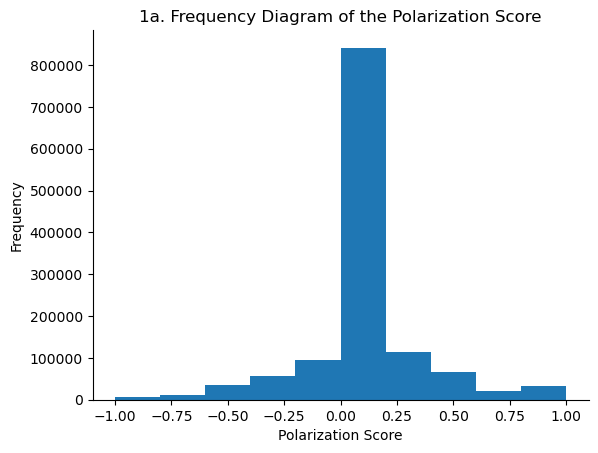

In [16]:
# Histogram of Y variable (polarity score)
fig, ax = plt.subplots()

tweet["polar_score"].plot.hist(bins=10, alpha=1)
ax.set_title("1a. Frequency Diagram of the Polarization Score")
ax.set_xlabel("Polarization Score")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

   We first explore how the Y variable looks in a histogram. This graph is a bi-model histogram, representing most of the polarity score lies between 0 and 0.25. This graph is consistent with the summary statistics above, with a mean of around 0.05, meaning that most people are lightly polarized.

For graphing analysis on X and Y variable, we need to re-classify the data.
Becasue one country/state might have multiple polarity score associated, I need to take all scores out and average them, then put the number under the country/state, before I can draw any graphs.
#### For X variables' relationship with Y variable graphs

In [17]:
# For X variable: created_time
c_time_country = {}
for a in range(len(tweet)):
    if tweet.iloc[a,22] not in c_time_country:
        c_time_country[tweet.iloc[a,22]] = [tweet.iloc[a,25]]
    elif tweet.iloc[a,22] in c_time_country:
        c_time_country[tweet.iloc[a,22]].append(tweet.iloc[a,25])
# Now take average of polarity score
ave_c_time = {}
for k,v in c_time_country.items():
    # v is the list of polarity scores for time k
    ave_c_time[k] = sum(v)/ float(len(v))
#ave_c_time.pop(np.nan) # clean obs that don't have a corresponding country, "nan" values

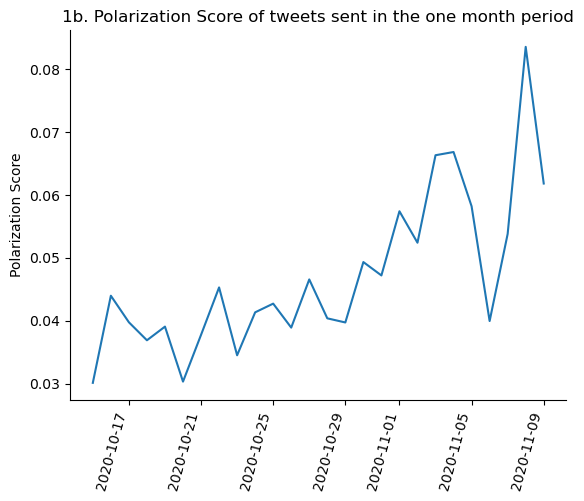

In [18]:
# now we plot the diagram
time_y = ave_c_time.keys()
score_t = ave_c_time.values()

fig, ax = plt.subplots()

ax.plot(time_y, score_t)
ax.set_title("1b. Polarization Score of tweets sent in the one month period")
ax.set_ylabel("Polarization Score")

for label in ax.get_xticklabels():
  label.set_rotation(75)
  label.set_ha('right')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
plt.show()

   The reason for choosing this X variable is explained above in the summary statistics section.
   In observing this graph, we see that, when it gets closer to the US election, people are getting more than more polarized across the one-month period. This graph follows our intuition as the debates over the election should become more aggressive over time.

In [19]:
# For X variable: country
dic_country = {}
for a in range(len(tweet)):
    if tweet.iloc[a,16] not in dic_country:
        dic_country[tweet.iloc[a,16]] = [tweet.iloc[a,25]]
    elif tweet.iloc[a,16] in dic_country:
        dic_country[tweet.iloc[a,16]].append(tweet.iloc[a,25])
# Now take average of polarity score
ave_country = {}
for k,v in dic_country.items():
    # v is the list of polarity scores for country k
    ave_country[k] = sum(v)/ float(len(v))
ave_country.pop(np.nan) # clean obs that don't have a corresponding country, "nan" values

0.05186563303781242

In [20]:
# because we have too many countries in this sample, darwing all 180 countries would be a mess
# I will ramdonly choose 5 countries from 6 continents (except Antarctica), becasue Antarctica has little data 
# and hopefully they can help us closly predict the parameter
# the 35 countries are in the list below
country_list = ["Japan","India","China","Singapore","Thailand","Nigeria","Ethiopia","Egypt", \
                "Morocco","Mali","Panama","Cuba","Canada","Mexico","Dominica","Peru","Brazil","Guyana","Chile",\
                "Colombia","Poland","France","Germany","Austria","Greece",\
                "Fiji","New Zealand","Australia","Papua New Guinea","Vanuatu"]
# Now we abstract data within the ave_state dictionary
selc_ave_country = {}
for i in country_list:
    sel_c_score = ave_country[i]
    selc_ave_country[i] = sel_c_score

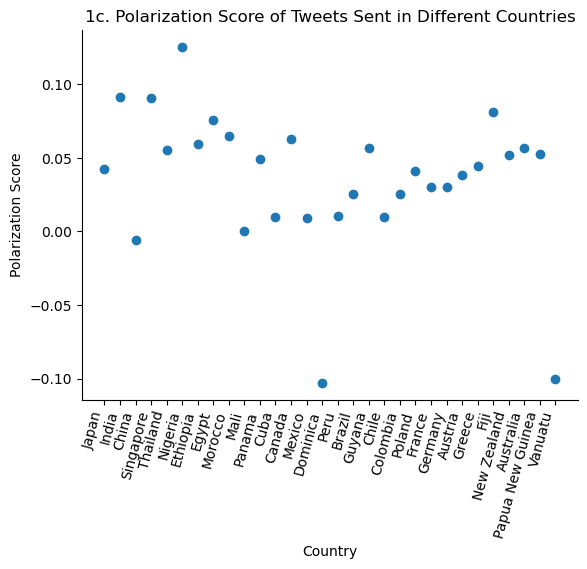

In [21]:
country = selc_ave_country.keys()
score_country = selc_ave_country.values()

fig, ax = plt.subplots()

ax.scatter(country, score_country)
ax.set_title("1c. Polarization Score of Tweets Sent in Different Countries")
ax.set_ylabel("Polarization Score")
ax.set_xlabel("Country")
# rotate the axis so we can see
for label in ax.get_xticklabels():
  label.set_rotation(75)
  label.set_ha('right')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()
# notice for this grap, we have to also combine our knowledge of geographic distribution before formal interpretation

   The reason for choosing this X variable is explained above in the summary statistics section.
   Observing this graph, I found that tweets from Asian countries are more polarized because I ranked the countries according to their continents. In contrast, tweets in North America are overall less polarized. This phenomenon could result from a cultural difference at first glance.

In [22]:
# For X variable: followers
dic_followers = {}
for a in range(len(tweet)):
    if tweet.iloc[a,11] not in dic_followers:
        dic_followers[tweet.iloc[a,11]] = [tweet.iloc[a,25]]
    elif tweet.iloc[a,11] in dic_followers:
        dic_followers[tweet.iloc[a,11]].append(tweet.iloc[a,25])
# Now take average of polarity score
ave_followers = {}
for k,v in dic_followers.items():
    # v is the list of polarity scores for country k
    ave_followers[k] = sum(v)/ float(len(v))
#ave_followers.pop(np.nan) # clean obs that don't have a corresponding country, "nan" values

In [23]:
# becasue X variables are not in order of smallest to largest, so I need to sort the keys
followers_keys = list(ave_followers.keys())
followers_keys.sort()
sorted_followers = {i: ave_followers[i] for i in followers_keys}

In [24]:
# for better visualization, we drop the last 4 biggest outliers
sorted_followers.pop(82396310.0)
sorted_followers.pop(82396325.0)
sorted_followers.pop(82417077.0)
sorted_followers.pop(82417099.0)

0.1953125

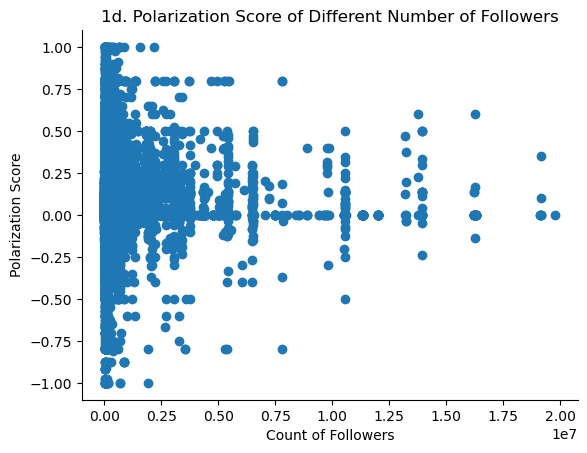

In [25]:
c_followers = sorted_followers.keys()
score_followers = sorted_followers.values()

fig, ax = plt.subplots()

ax.scatter(c_followers, score_followers)
ax.set_title("1d. Polarization Score of Different Number of Followers")
ax.set_ylabel("Polarization Score")
ax.set_xlabel("Count of Followers")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

   The reason for choosing this X variable is explained above in the summary statistics section.
   Even though the scatters and the dots are spread out largly, there is still a sign of a positive relationship. This graph shows an upward-sloping relationship between fans owned and polarization score. One way to see this is through comparing the lowest polarization score given the count of followers. This graph says that people with more fans, or people more influential on Twitter, are likely to send out more polarized tweets.

In [26]:
# For X variable: join_year
dic_j_year = {}
for a in range(len(tweet)):
    if tweet.iloc[a,23] not in dic_j_year:
        dic_j_year[tweet.iloc[a,23]] = [tweet.iloc[a,25]]
    elif tweet.iloc[a,23] in dic_j_year:
        dic_j_year[tweet.iloc[a,23]].append(tweet.iloc[a,25])
# Now take average of polarity score
ave_j_year = {}
for k,v in dic_j_year.items():
    # v is the list of polarity scores for country k
    ave_j_year[k] = sum(v)/ float(len(v))
ave_j_year.pop(1970) # pop out the outlier

0.0

In [27]:
join_year_keys = list(ave_j_year.keys())
join_year_keys.sort()
sorted_ave_j_year = {i: ave_j_year[i] for i in join_year_keys}

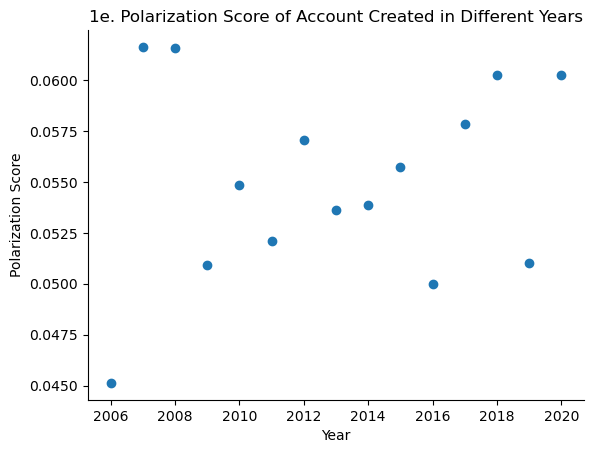

In [28]:
# start drawing the graph
join_year = sorted_ave_j_year.keys()
score_join = sorted_ave_j_year.values()

fig, ax = plt.subplots()

ax.scatter(join_year, score_join)
ax.set_title("1e. Polarization Score of Account Created in Different Years")
ax.set_ylabel("Polarization Score")
ax.set_xlabel("Year")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

   The reason for choosing this X variable is explained above in the summary statistics section.
   In observing this graph, we see an upward-sloping relationship between join_year and polarization score. So this graph is saying that people who registered later, people who have less internet experience, or people who are likely to be younger are likely to send out more polarized tweets.

In [29]:
# For X variable: state
dic_state = {}
for a in range(len(tweet)):
    if tweet.iloc[a,18] not in dic_state and tweet.iloc[a,16] == "United States of America":
        dic_state[tweet.iloc[a,18]] = [tweet.iloc[a,25]]
    elif tweet.iloc[a,18] in dic_state and tweet.iloc[a,16] == "United States of America":
        dic_state[tweet.iloc[a,18]].append(tweet.iloc[a,25])
# Now take average of polarity score
ave_state = {}
for k,v in dic_state.items():
    # v is the list of polarity scores for country k
    ave_state[k] = sum(v)/ float(len(v))
ave_state.pop(np.nan) # clean obs that don't have a corresponding state, "nan" values

0.12417328042328042

In [30]:
# becasue there are too many states, we will focus on the top 20 biggest states in the United States by population
# those are: California, Texas, Florida, New York, Pennsylvania, Illinois, Ohio, Georgia, North Carolina, 
# Michigan, New Jersey, Virginia, Washington, Arizona, Massachusetts, Tennessee, Indiana, Maryland, Missouri
# and Colorado
# List taken from: https://worldpopulationreview.com/states
state_list = ["California","Texas","Florida","New York","Pennsylvania","Illinois","Ohio","Georgia", \
              "North Carolina","Michigan","New Jersey","Virginia","Washington","Arizona","Massachusetts",\
              "Tennessee","Indiana","Maryland","Missouri","Colorado"]
# Now we abstract data within the ave_state dictionary
us_ave_state = {}
for i in state_list:
    state_score = ave_state[i]
    us_ave_state[i] = state_score

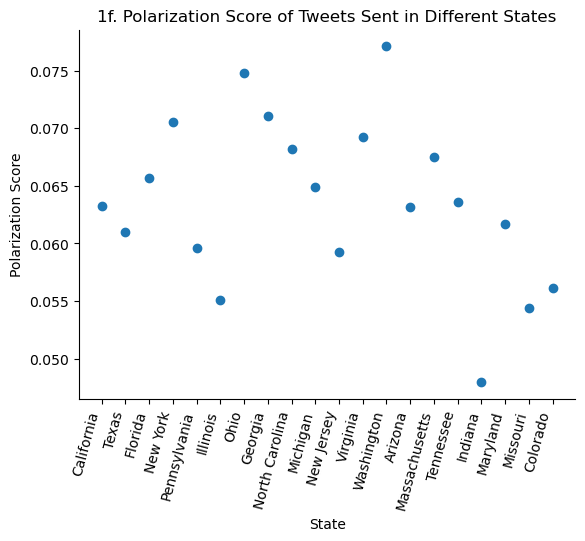

In [31]:
# now we can plot the graph
the_state = us_ave_state.keys()
score_state = us_ave_state.values()

fig, ax = plt.subplots()

ax.scatter(the_state, score_state)
ax.set_title("1f. Polarization Score of Tweets Sent in Different States")
ax.set_ylabel("Polarization Score")
ax.set_xlabel("State")
# rotate the axis so we can see
for label in ax.get_xticklabels():
  label.set_rotation(75)
  label.set_ha('right')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()
# notice for this grap, we have to also combine our knowledge of geographic distribution before formal interpretation

   The reason for choosing this X variable is explained above in the summary statistics section.
   Observing this graph, we have to consider the location of where the states. After taking into the effect of that, we see that people who live on the east side of the United States tend to send more polarized tweets than those on the west side. I suspect it's because of the cultural difference and people's living habits between the two coasts.

# 2. Project 2

## 2.1 The Message

From the above general graphs, we get to know that the following relationships may exist between the X and Y variables:

- People get more polarized when it gets closer to the election date (created_time)
- Residents in the east of the US tend to send out more positive tweets than that in the west (states)
- Asian countries tend to have more positive sentiments than other continents (countries)
- Younger people tend to send out more positive content (join_year)
- The more fans an account has, the more positive content it sends (fans_owned)

Because in the above graphs, we already see a significant relationship for X variable "time"(tweet posted time). Thus, in the following section, I will focus on the other four variables where I can dig deeper and see if the true significant relationships exist.
We will now dig into the details and draw better graphs and maps to show the remaining relationships.

### 2.1.1 Detailed Graphs

#### Polarization socre VS. location of the tweet within the US

We draw two graphs to explore whether and by how much people's polarization scores differ across the United States. Two graphs show the ten states with the highest and lowest polarization scores, respectively. We start with the highest polarization score and then the lowest.

In [32]:
# Frist I sort the values of polarization score from highest to lowest and vice versa
# This dictionary is taken from Project 1 which was already cleaned and taken from the raw dataset
ave_state = dict(sorted(ave_state.items(), key=lambda item: item[1]))
ave_state_low = dict(list(ave_state.items())[1:11])
ave_state_high = dict(list(ave_state.items())[-11:-1])
# I drop one lowest and one highest for better visualization and potential errors
# now transfer low to dataframe object
low_state = pd.DataFrame(ave_state_low, index=['0']).transpose()
low_state = low_state.rename(columns={'0': 'Polarization Score'})
# now transfer high to dataframe object
high_state = pd.DataFrame(ave_state_high, index=['0']).transpose()
high_state = high_state.rename(columns={'0': 'Polarization Score'})

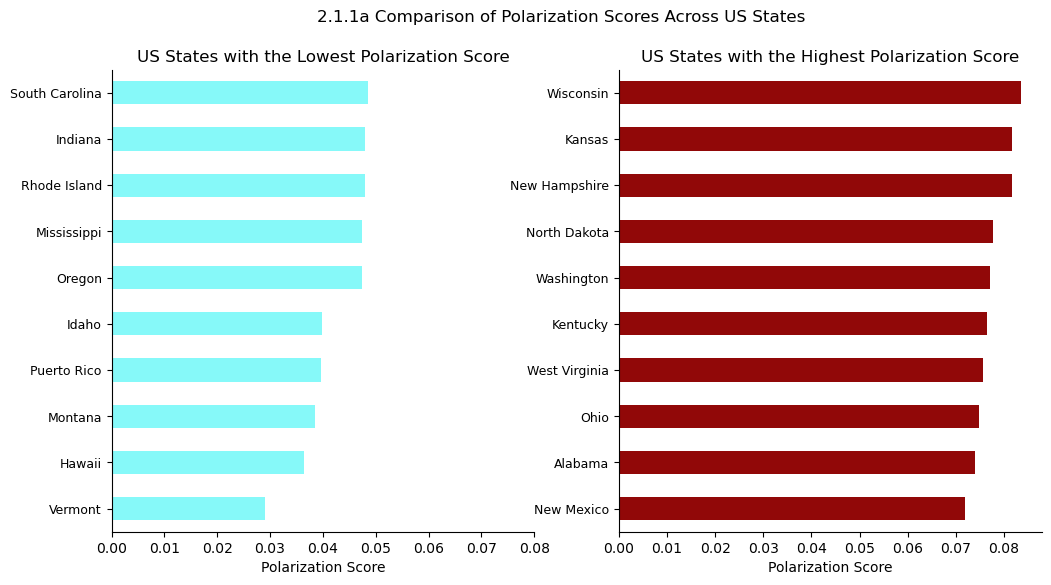

In [33]:
import colorsys

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# plot data on first subplot
low_state["Polarization Score"].plot(kind="barh", ax=ax1, color=colorsys.hls_to_rgb(0.5, 0.75, 0.9))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_title("US States with the Lowest Polarization Score")
ax1.tick_params(axis='y', labelsize=9)  # set font size for y-axis
ax1.set_xlabel("Polarization Score")  # set label for x-axis
ax1.set_xlim([0, 0.08])  # set x range to better compare relatively

# plot data on second subplot
high_state["Polarization Score"].plot(kind="barh", ax=ax2, color=colorsys.hls_to_rgb(0, 0.3, 0.9))
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title("US States with the Highest Polarization Score")
ax2.tick_params(axis='y', labelsize=9)  # set font size for y-axis
ax2.set_xlabel("Polarization Score")  # set label for x-axis
# saturation of colour 0.3 and 0.75 should work 
# whether you have a black-and-white printer or a coloured printer


# add a title to the figure
fig.suptitle('2.1.1a Comparison of Polarization Scores Across US States')

# display the plot
plt.show()

We can refer to some interesting conclusions from this graph:
- Even the lowest-scoring states have scores above 0, meaning people in the US are at least somewhat positively polarized.
- I intentionally set both axes into the same scale of 0.08 to better compare - and it turns out that the difference between the highest and lowest scores is not big(0.05 vs 0.08). Thus, we should not conclude that there is a significant difference in the polarization score across the country.
- However, if we are to compare, we find that most high-scoring states are in the east of the US, while lots of low-scoring states are in the south. So maybe we can refer to the fact that residents in the east of the US tend to send out more positive tweets than those in the west.

However, we will address this question better in the below mapping section, where I directly show the map for the polarization within the US. I am offering this graph here so we can have different perspectives to see if the phenomenon we observe is valid.

#### Polarization socre VS. User Registered Time

To explore closer on whether and by how much people's polarization scores differ according to their registered time, we draw the following graph.

In [34]:
# get the data already sorted above to dataframe object
j_time_df = pd.DataFrame(sorted_ave_j_year, index=['0']).transpose()
j_time_df = j_time_df.rename(columns={'0': 'Polarization Score'})
j_time_df.head()

,Polarization Score
2006,0.045139
2007,0.061613
2008,0.061546
2009,0.050927
2010,0.054846


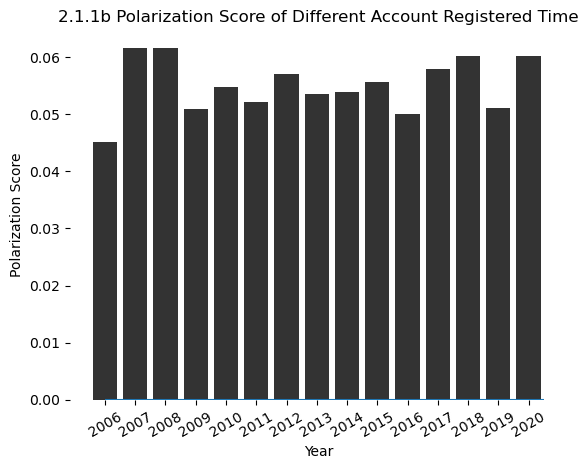

In [35]:
fig, ax = plt.subplots()

colors = ["r" if x < 0 else "k" for x in j_time_df["Polarization Score"].values] # define colour
bars = ax.bar(np.arange(len(colors)), j_time_df["Polarization Score"].values, color=colors, alpha=0.8)
ax.hlines(0, 0, 14.5) # get the bottom line of the graph
ax.set_xticks(np.arange(len(j_time_df.index)))
ax.set_xticklabels(j_time_df.index)
ax.tick_params(axis='x', labelrotation=30)# rotate the x-axis so we see better

ax.set_title("2.1.1b Polarization Score of Different Account Registered Time")
# set the axis
plt.ylabel("Polarization Score")
plt.xlabel("Year")
# remove the boundaries
for _spine in ["right", "top", "left", "bottom"]:
    ax.spines[_spine].set_visible(False)

This graph proves the otherwise to the conclusion we made above. In the scatter plot in Project 1, we see a slight increase in the polarization score as the account registered time grows - I thought that made sense because I thought intuitively that younger people tend to be more polarized. However, there was little of a big difference in this bar plot. The potential reason could be the misleading scale of the y-axis. 

The polarization score overall is very stable across the account registered year in this bar plot. Whether a person has larger or smaller exposure to Twitter will not essentially affect how polarized this person is on social media.

However, the variable "registered time" is ambiguous and could be connected to various factors. For example, we cannot see clear relationships in this bar plot. Is it because our sample is too mixed, and we should also control other variables? 

Therefore, I will create a map below for this X variable in the mainland United States exclusively, narrowing down the data range and controlling for other potential lurking variables - just to see how the registered time correlate to location and polarization score.

#### Polarization socre VS. Number of Fans Owned

To explore closer whether and by how much people's polarization scores differ with the different numbers of followers, I update the graph from Project 1. Because a single scatter plot makes people hard to identify the trend, I will add a trend line onto the graph and see if the relationship between the X and Y truly exists.

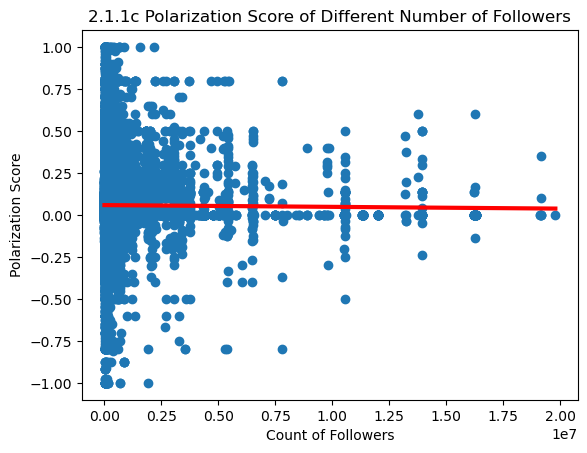

In [36]:
c_followers = list(sorted_followers.keys())
score_followers = list(sorted_followers.values())

# Fit a polynomial line of degree 1 (i.e., a straight line) to the data
z = np.polyfit(c_followers, score_followers, 1)
p = np.poly1d(z)

# Plot the scatter plot and the trend line
plt.scatter(c_followers, score_followers)
plt.plot(c_followers, p(c_followers), "-", color="red", linewidth=3)
plt.title("2.1.1c Polarization Score of Different Number of Followers")
plt.ylabel("Polarization Score")
plt.xlabel("Count of Followers")
plt.show()

Thus, our conclusion in project 1 is likely wrong. In project 1's findings, I inferred that people with more fans tend to be more polarized by visualization. 

However, with the help of an almost perfect horizontal trend line, we should infer that:
- There isn't sufficient proof to say a significant or apparent relationship exists between fans owned and polarization score.

## 2.2 Maps and Interpretation

### 2.2.1 Map for Polarization Within the US (X: States in the US, Y: Polarization Score)

In [37]:
# I will first get the sorted list of the polarization score and the US state list here first
# I will use low_state dataframe just for convience
map_ave_state = pd.DataFrame(ave_state, index=['0']).transpose()
map_ave_state = map_ave_state.rename(columns={'0': 'Polarization Score'})
map_ave_state.head()

,Polarization Score
Guam,-0.071429
Vermont,0.029111
Hawaii,0.036503
Montana,0.038532
Puerto Rico,0.039662


In [38]:
# now we get the state gpd data
state_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_5m.zip")
# now we merge the two files
merge_state_map = state_df.merge(map_ave_state, left_on="NAME", right_index=True, how="inner")
# drop a few outliers due to small amount of observations
# and we will focus on only the mainland states
# because only mainland states concern the research questions
condition_state_1 = (state_df['NAME'] == 'Guam') # specify the condition to delete
merge_state_map = merge_state_map.drop(state_df[condition_state_1].index)
condition_state_3 = (state_df['NAME'] == 'Hawaii') # specify the condition to delete
merge_state_map = merge_state_map.drop(state_df[condition_state_3].index)
condition_state_2 = merge_state_map.bounds['maxx'] >= 165
merge_state_map = merge_state_map.loc[~condition_state_2] # delete rows that satisfy the condition
condition_state_4 = merge_state_map.bounds['miny'] <= 20
merge_state_map = merge_state_map.loc[~condition_state_4] # delete rows that satisfy the condition
# last but not least, we want to standardize the polarization score so it's from -1 to 1
merge_state_map['norm_polar'] = (2*(merge_state_map['Polarization Score']-\
                                    merge_state_map['Polarization Score'].min()) \
                             / (merge_state_map['Polarization Score'].max()-\
                                merge_state_map['Polarization Score'].min())) - 1
# now take a look at the gpd file
merge_state_map.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,Polarization Score,norm_polar
0,01,01779775,0400000US01,01,AL,Alabama,00,131173688951,4593686489,"MULTIPOLYGON (((-88.04374 30.51742, -88.03661 ...",0.074003,0.646834
2,04,01779777,0400000US04,04,AZ,Arizona,00,294198560125,1027346486,"POLYGON ((-114.79968 32.59362, -114.80939 32.6...",0.063163,0.249168
3,08,01779779,0400000US08,08,CO,Colorado,00,268429343790,1175112870,"POLYGON ((-109.06025 38.59933, -109.05954 38.7...",0.056147,-0.008199
4,09,01779780,0400000US09,09,CT,Connecticut,00,12542638347,1815476291,"POLYGON ((-73.72777 41.10070, -73.69595 41.115...",0.051929,-0.162941
5,12,00294478,0400000US12,12,FL,Florida,00,138924199212,31386038155,"MULTIPOLYGON (((-80.75164 24.85725, -80.72906 ...",0.065697,0.342136


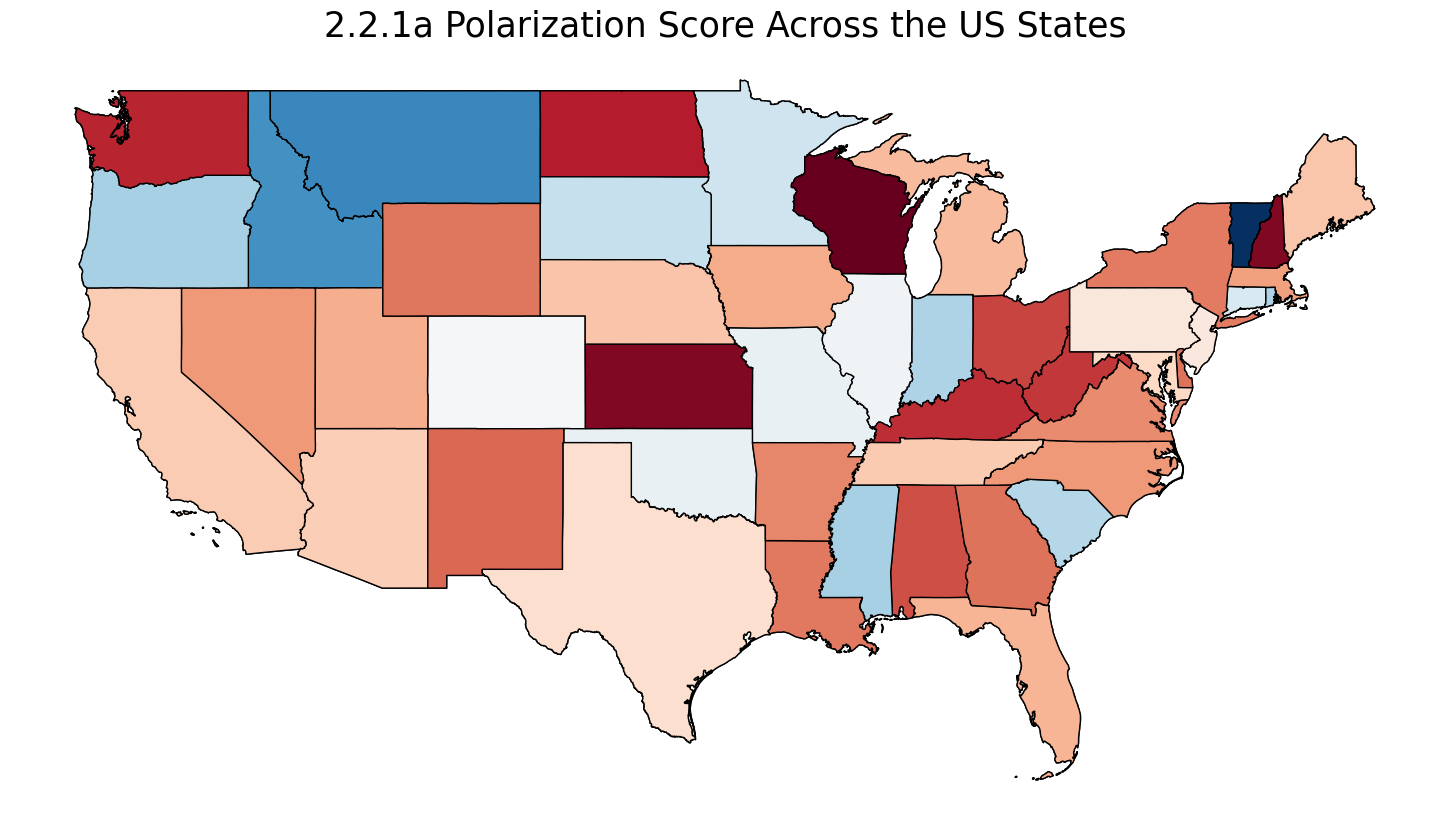

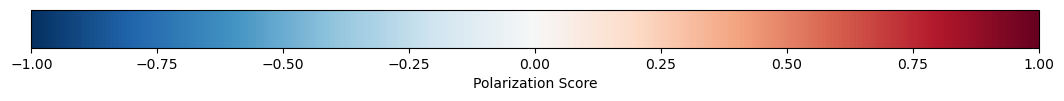

In [39]:
# now we start to graph
# start with the U.S. map layer
fig, gax = plt.subplots(figsize=(20,10))
merge_state_map.plot(ax=gax, edgecolor='black',color='white')
# then we map the colour of polarization score
merge_state_map.plot(
    ax=gax, edgecolor='black', column="Polarization Score", legend=False, cmap='RdBu_r',
)
plt.title('2.2.1a Polarization Score Across the US States', fontsize = 25)
plt.axis('off')

# we now create a colorbar
fig, ax = plt.subplots(figsize=(13, 1))
fig.subplots_adjust(bottom=0.5)

cmap = 'RdBu_r'
norm = mpl.colors.Normalize(vmin=-1, vmax=1)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Polarization Score')

# end of colorbar
plt.show()

This map shows a better visualization of the polarization score across the United States. Meanwhile, we inferred from the previous part that: we should not conclude that there is a significant difference in the polarization score across the country, and if we are to compare, we find that most high-scoring states are in the east of the US, while lots of low scoring states are in the south.

The previous conclusion that "there isn't a significant difference in the polarization score across the country" is true, as most states are positively polarized across the United States. However, the conclusion that "most high-scoring states are in the east of the US, while lots of low-scoring states are in the south" might not be true. Low-scoring states are mostly in the southwest instead of the west, while the eastern states tend to be more polarized overall.

Thus, the official conclusion regarding polarization score and the geographical location within the United States is as follows:
- We should not conclude that there is a significant difference in the polarization score across the country
- However, comparatively, low polarization scoring states are mostly in the southwest, while the eastern states tend to be more polarized overall.

### 2.2.2 Map for Account Created Time (X: Average time of Year when the account was created in the US)

The only two relationships left to dig deeper into are the following:
- Asian countries tend to have more positive sentiments than other continents (countries)
- Younger people tend to send out more positive content (join_year)
I will use the remaining two maps to research more on those relationships.

Meanwhile, as mentioned above: 

The variable "registered time" is ambiguous and could be connected to various factors. For example, we cannot see clear relationships in the above bar plot. Is it because our sample is too mixed, and we should also control for other variables? 

Therefore, I am going to create a map here for this X variable(registered time) in the mainland United States exclusively, narrowing down the data range and controlling for other potential lurking variables - to see how the registered time correlate to location and polarization score.

In [40]:
# For X variable: join_year
dic_j_year_map = {}
for a in range(len(tweet)):
    if tweet.iloc[a,18] not in dic_j_year_map and tweet.iloc[a,16] == "United States of America":
        dic_j_year_map[tweet.iloc[a,18]] = [tweet.iloc[a,-3]]
    elif tweet.iloc[a,18] in dic_j_year_map and tweet.iloc[a,16] == "United States of America":
        dic_j_year_map[tweet.iloc[a,18]].append(tweet.iloc[a,-3])
# Now take average of year
ave_j_year_map = {}
for k,v in dic_j_year_map.items():
    # v is the list of average created year rounded for country k
    ave_j_year_map[k] = round(sum(v)/ float(len(v)))

In [41]:
# transfer the list into a pandas object
state_year_map = pd.DataFrame(ave_j_year_map, index=['0']).transpose()
state_year_map = state_year_map.rename(columns={'0': 'Ave Registered Year'})
state_year_map.head()

,Ave Registered Year
Oregon,2011
District of Columbia,2013
California,2013
Ohio,2014
Pennsylvania,2013


In [42]:
# because we already have a US mainland map editted
# I will merge this new data into it and start drawing
merge_state_map = merge_state_map.merge(state_year_map, left_on="NAME", right_index=True, how="inner")
merge_state_map.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,Polarization Score,norm_polar,Ave Registered Year
0,01,01779775,0400000US01,01,AL,Alabama,00,131173688951,4593686489,"MULTIPOLYGON (((-88.04374 30.51742, -88.03661 ...",0.074003,0.646834,2012
2,04,01779777,0400000US04,04,AZ,Arizona,00,294198560125,1027346486,"POLYGON ((-114.79968 32.59362, -114.80939 32.6...",0.063163,0.249168,2013
3,08,01779779,0400000US08,08,CO,Colorado,00,268429343790,1175112870,"POLYGON ((-109.06025 38.59933, -109.05954 38.7...",0.056147,-0.008199,2013
4,09,01779780,0400000US09,09,CT,Connecticut,00,12542638347,1815476291,"POLYGON ((-73.72777 41.10070, -73.69595 41.115...",0.051929,-0.162941,2013
5,12,00294478,0400000US12,12,FL,Florida,00,138924199212,31386038155,"MULTIPOLYGON (((-80.75164 24.85725, -80.72906 ...",0.065697,0.342136,2013


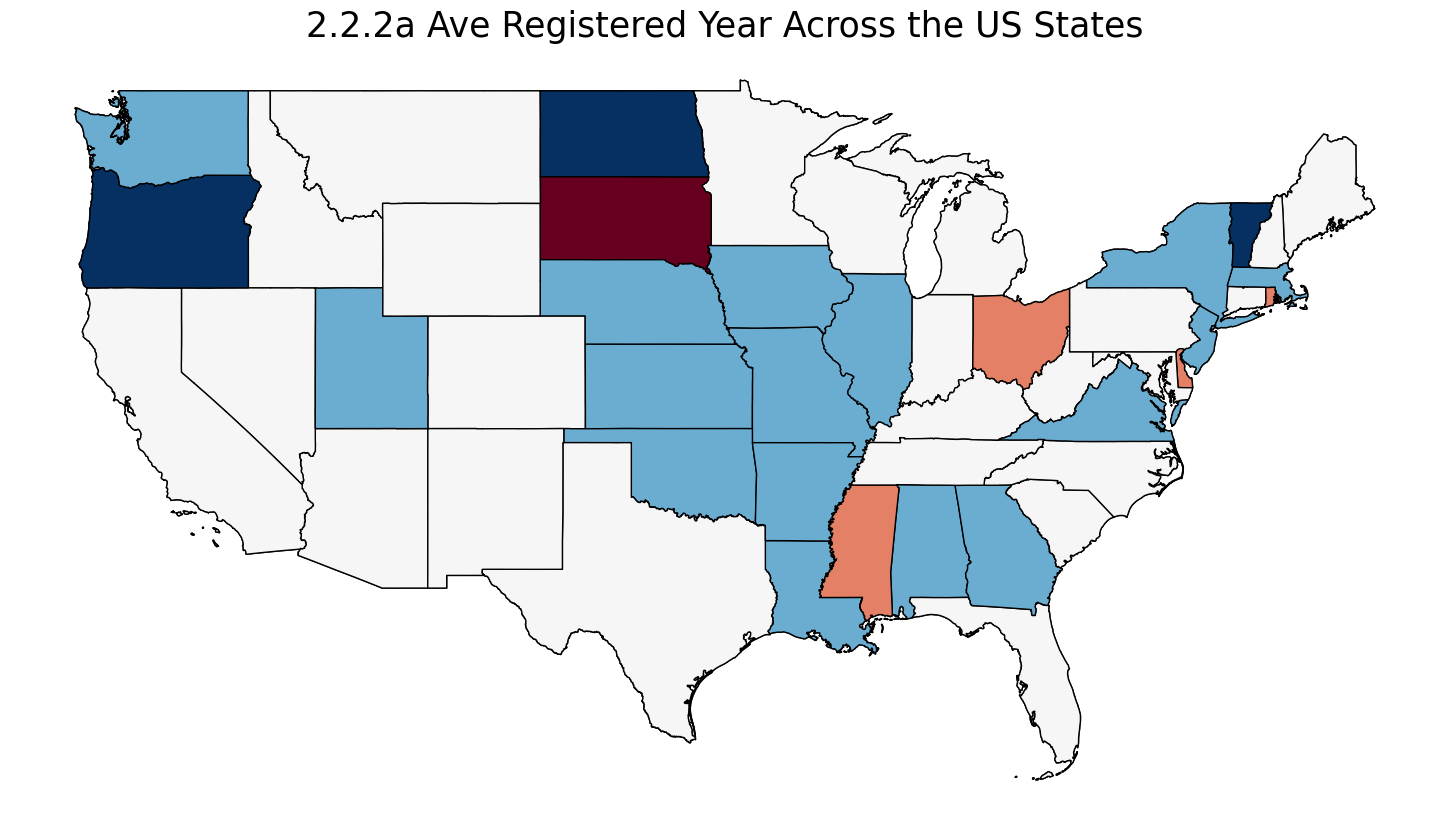

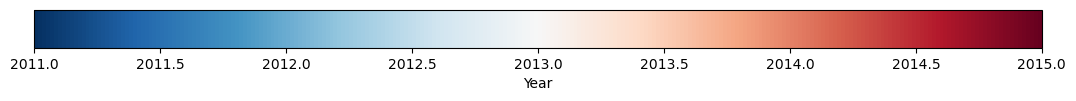

In [43]:
# now we start to graph
fig, gax = plt.subplots(figsize=(20,10))
merge_state_map.plot(ax=gax, edgecolor='black',color='white')
# then we map the colour of polarization score
merge_state_map.plot(
    ax=gax, edgecolor='black', column="Ave Registered Year", legend=False, cmap='RdBu_r',
)
plt.title('2.2.2a Ave Registered Year Across the US States', fontsize = 25)
plt.axis('off')

# we now create a colorbar
fig, ax = plt.subplots(figsize=(13, 1))
fig.subplots_adjust(bottom=0.5)

cmap = 'RdBu_r'
norm = mpl.colors.Normalize(vmin=2011, vmax=2015)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Year')

# show the graph
plt.show()

From this graph alone, we can identify that most states' average Twitter accounts registered time ranges from 2012 to 2014. Meanwhile, most western states have a registered time of 2013, while many middle and eastern states have a registered time of 2011.

However, this map alone does not tell any correlations or relationships. Thus, I will draw the two maps together to see potential relationships.

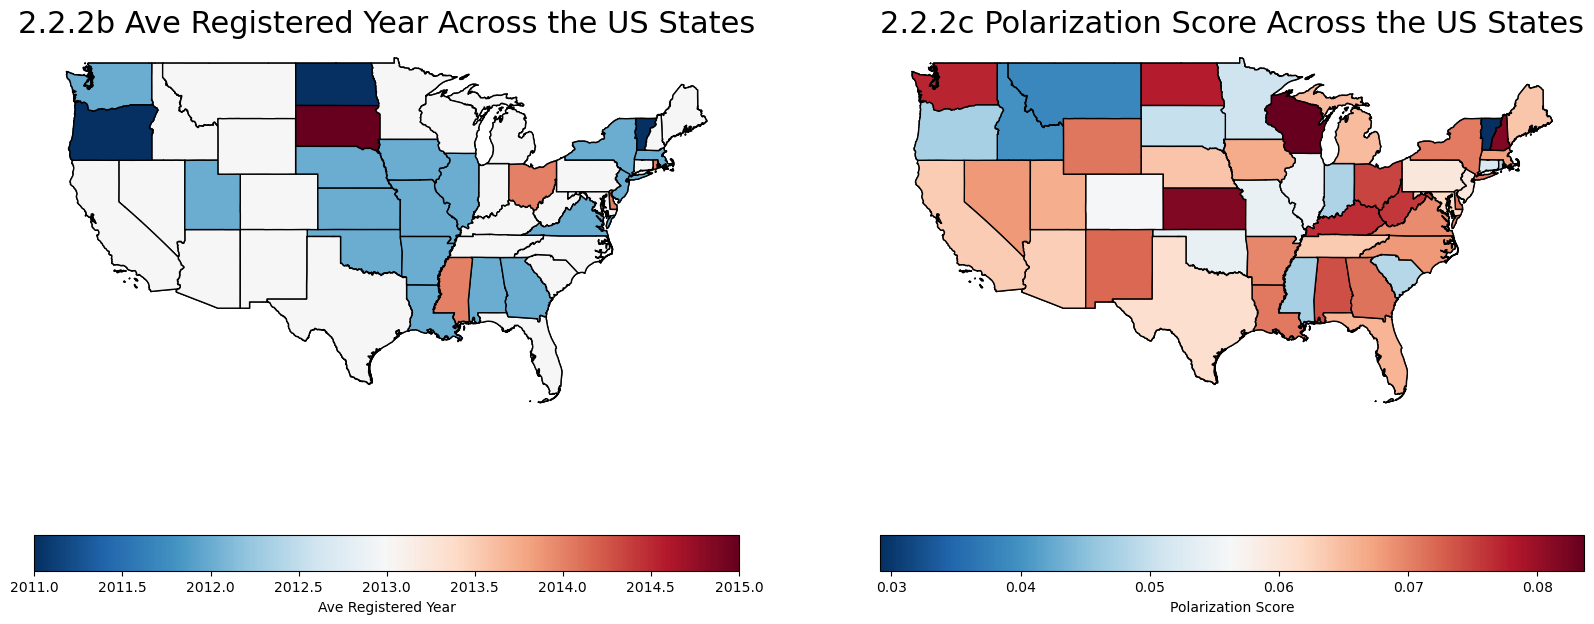

In [44]:
# now I want to draw this map with the polarization map together
# so I can see potential relationships

import matplotlib as mpl
# create figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,10))

# plot Ave Registered Year on the first subplot
merge_state_map.plot(ax=ax1, edgecolor='black', color='white')
merge_state_map.plot(ax=ax1, edgecolor='black', column="Ave Registered Year", legend=False, cmap='RdBu_r')
ax1.set_title('2.2.2b Ave Registered Year Across the US States', fontsize=22)
ax1.axis('off')
# plot Polarization Score on the second subplot
merge_state_map.plot(ax=ax2, edgecolor='black', color='white')
merge_state_map.plot(ax=ax2, edgecolor='black', column="Polarization Score", legend=False, cmap='RdBu_r')
ax2.set_title('2.2.2c Polarization Score Across the US States', fontsize=22)
ax2.axis('off')

# create a colorbar for the first map
fig.colorbar(ax1.collections[1], ax=ax1, orientation='horizontal', label='Ave Registered Year')
# create a colorbar for the second map
fig.colorbar(ax2.collections[1], ax=ax2, orientation='horizontal', label='Polarization Score')
# show the plot
plt.show()

Here are two graphs together, the one on the left is a US map with a different Twitter account registered time; the one to the right is the US map with varying polarization scores.

In the previous parts, with graph 2.1.1b, we conclude that there isn't any strong relationship between the polarization score and the account-created time. However, when comparing these two graphs, there is some correlation.

We can see that most states that are more polarized(red in the right graph) were registered around 2013(white in the left graph); most states that are less polarized(light blue in the right graph) were registered around 2011(deep blue in the left graph); especially when we look at the states in the south-west. Thus, we can infer that: the later the account is created, the more polarized the posted content is. This conclusion aligns with the observation in graph 1e.

The potential reason for observing a trend here could be mentioned above: there might be unobserved lurking variables. We get to see a better relationship as I narrow down the data range and potentially eliminate the effect of those variables.

However, to dig deeper, we must run a multi-regression model and control for other factors to see the real trend.

### 2.2.3 Maps for Polarization Acorss the World (X: Countries in the World, Y: Polarization Score)

To research on the last relationship, polarization score vs different countries, I draw a world map to show potential relationships.

In [45]:
# We use the following code to generate 1 polarization score for 1 country 
# (taking average of multiple scores)
# For X variable: country
dic_country_map = {}
for a in range(len(tweet)):
    if tweet.iloc[a,16] not in dic_country_map:
        dic_country_map[tweet.iloc[a,16]] = [tweet.iloc[a,25]]
    elif tweet.iloc[a,16] in dic_country_map:
        dic_country_map[tweet.iloc[a,16]].append(tweet.iloc[a,25])
# Now take average of polarity score
ave_country_map = {}
for k,v in dic_country_map.items():
    # v is the list of polarity scores for country k
    ave_country_map[k] = sum(v)/ float(len(v))
ave_country_map.pop(np.nan) # clean obs that don't have a corresponding country, "nan" values

0.05186563303781242

In [46]:
# transfer the dictionary into a list first, so we can manually change some data to better merge the datasets
country_keys = list(ave_country_map.keys())
country_values = list(ave_country_map.values())
# there are two countries that hvae different names in the two dataset
# so I am going to change the name in the tweet dataset to match the other one
for i in range(len(country_keys)):
    if country_keys[i] == "Republic of the Congo":
        country_keys[i] = "Congo"
    elif country_keys[i] == " South Sudan":
        country_keys[i] = "S. Sudan"
# combine the two lists and generate a dataframe object
whole_country_list = [country_keys] + [country_values]
country_map = pd.DataFrame(whole_country_list, index=['country','polarization']).transpose()
# drop a few outliers due to small tweet observations
country_map = country_map.drop(132)
country_map = country_map.drop(186)
country_map = country_map.drop(184)
country_map = country_map.drop(179)
# we want to normalize the value from -1 to 1
country_map['norm_polar'] = (2*(country_map['polarization']-country_map['polarization'].min()) \
                             / (country_map['polarization'].max()-country_map['polarization'].min())) - 1
country_map.head()

,country,polarization,norm_polar
0,United States of America,0.063863,0.054727
1,United Kingdom,0.077287,0.116141
2,Germany,0.029951,-0.100432
3,United States,0.060189,0.037913
4,Australia,0.056583,0.021416


In [47]:
# now we import the world map and start drawing
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [48]:
# now we put the ploarization score into the world data
country_polar_map = world.merge(country_map, left_on="name", right_on="country", how="inner")
country_polar_map.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,country,polarization,norm_polar
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",Fiji,0.081389,0.134908
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Tanzania,0.052004,0.00047
2,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,0.06243,0.048169
3,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",United States of America,0.063863,0.054727
4,18513930.0,Asia,Kazakhstan,KAZ,181665,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",Kazakhstan,0.072357,0.093585


/Users/gavinhao/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


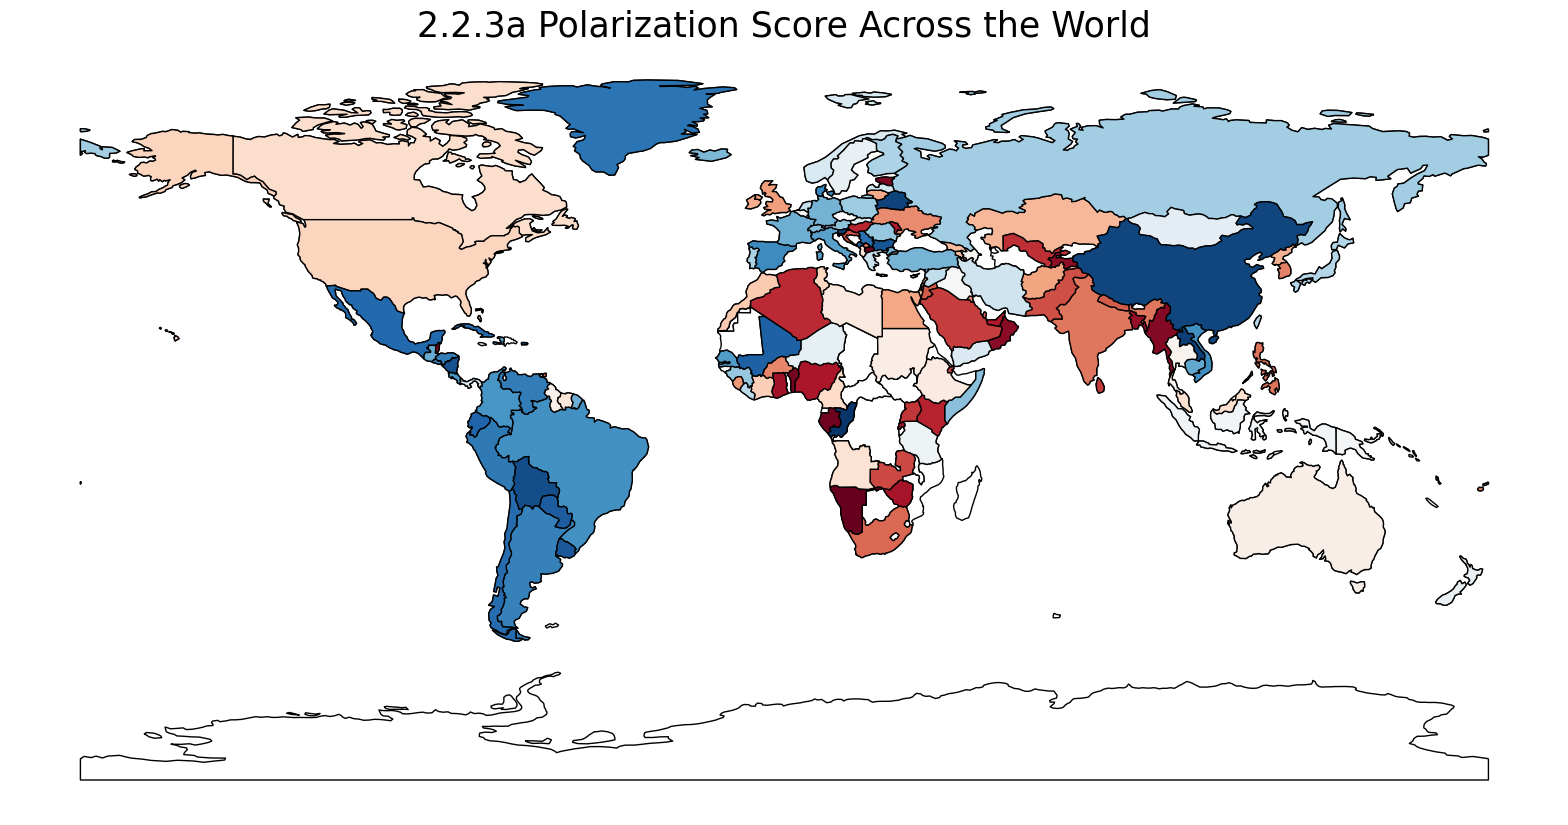

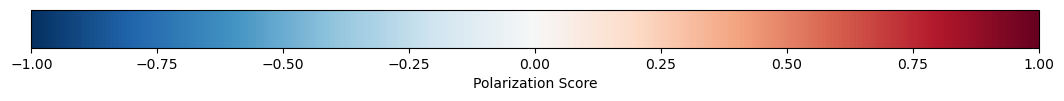

In [49]:
# now we start to graph
# start with the world map layer
fig, gax = plt.subplots(figsize=(20,10))
world.plot(ax=gax, edgecolor='black',color='white')
# then we map the colour of polarization score
country_polar_map.plot(
    ax=gax, edgecolor='black', column="norm_polar", legend=False, cmap='RdBu_r',
)
plt.title('2.2.3a Polarization Score Across the World', fontsize = 25)
plt.axis('off')
# we now create a colorbar
fig, ax = plt.subplots(figsize=(13, 1))
fig.subplots_adjust(bottom=0.5)

cmap = 'RdBu_r'
norm = mpl.colors.Normalize(vmin=-1, vmax=1)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Polarization Score')
# end of colorbar
plt.show()

This graph shows that polarizations of tweets across the world have huge differences. North America tends to have more positive tweets, while South America and Europe tend to have more negative tweets. While Australian countries were in the middle ground - not too positive nor negative, African countries had mixed polarization scores across the continent with some missing observations(as no tweets are posted from those countries).

This conclusion aligns with the conclusion in project 1.

## 2.3 Conclusion

From the above graphs and maps, although some graphs contradict each other, we can still infer several important conclusions. The conclusions are: when it gets closer to the US election, people are getting more than more polarized; the polarization score difference is not significant across the US, but comparatively, most high-scoring states are in the east of the US, while lots of low scoring states are in the south; Asian countries tend to have more positive sentiments than other continents; and that there are no significant relationships between fans owned and polarization score. 

However, one X variable exhibits an ambiguous relationship to the polarization score. The X variable is account registered time, which is an indicator of the user's previous exposure to the internet or the person's age. The relationship is ambiguous because there is a high chance this variable is affected by another lurking variable. I tried to eliminate the effects by narrowing the range in the above map. Still, I will need more tools like muti-regression to derive a more specific conclusion. Thus, the conclusion up to this point is that this X variable(user join date) exhibits an ambiguous relationship to the polarization score.

Still, even though we believe the conclusions on the other four X variables are well-supported, we must be aware of the potential existence of the lurking variables. We can better control those lurking variables if we find an approach for a multi-regression model for all X variables. Meanwhile, even though TextBlob is believed to accurately identify the polarization score on people's speeches, AI and natural language processing is still a developing field. Therefore, we should be more careful when processing those data.
   
In this report and dataset, we only observed the relationships to certain important X variables. In the future, we could explore how those polarization scores reflect people's emotions or living standards; and find some correlations or predictions between the five variables and people's emotional standards.